# Bin Packing Problem

The bin packing problem is an optimization problem where given a number of items with a respective weight, we look at the best arrangement of the items to minimize the number of bins or containers needed. The restriction, in this case, is the capacity of the bins which cannot surpass a certain weight. This problem has many real applications in areas as loading trucks with weight restriction, filling up containers, and FPGA semiconductors chip desing. 

In terms of complexity, the bin packing problem is a NP-hard problem. However, there are efficient algortihms that allows the arrange of large number of items. One of them is the first fit, which provides a fast but not optimal solution of the problem. 

In this tutorial, we will explore the solution of the bin packing problem, using a quantum computing representation in terms of quaratic unconstraint binary optimizatio (QUBO) and using the quantum approximation optimization (QAOA) algorithm. 

## 1. Problem statement

$$\underset{\chi, \xi}{minimize}\sum_{i=1}^m \chi_i$$

subject to:
$$\sum_{i=1}^m \xi_{ij} = 1 \qquad j=1,...,n$$
$$\sum_{j=1}^n w_{j}\xi_{ij} \le Q \chi_i \qquad i = 1, ..., m$$
$$\xi_{ij}\in  \{0,1\} \qquad i=1,..,m \qquad j=1,..,n$$
$$\chi_{i}\in  \{0,1\} \qquad i=1,..,m $$

- n is the number of items
- m is the number of bins
- $w_j$ is the j-th item weight
- $\chi_i$ is i-th bin
- $\xi_{ij}$ is the variable that represent if the item j is in the bin i.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

from qiskit import BasicAer
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import CplexOptimizer, MinimumEigenOptimizer
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer
from qiskit_optimization import QuadraticProgram

from qiskit_optimization.converters import InequalityToEquality, IntegerToBinary, LinearEqualityToPenalty

In [2]:
def data_bins(results, wj, n, m, l=0, simplify=False):
    """save the results on a dictionary with the three items, bins, items, and index.
    results (cplex.solve): results of the optimization
    wj: (array (1,m): weights of the items
    n: (int) number of items
    m: (int) number of bins
    """
    if simplify:
        bins = np.ones((m,))
        if m-l > 0: 
            bins[m-l-1:m] = results[:m-l]
        items = np.zeros((m,n))
        items[:,1:] =  results[m-l:(m-1)*n+m-l].reshape(m,n-1)
        items[0,0] = 1
        items = items.reshape(m,n) * wj
        return {"bins":bins, "items":items,"index":np.arange(m)}
    else:        
        return {"bins":results[:m], "items":results[m:m+m*n].reshape(m,n) * wj, "index":np.arange(m)}
def plot_bins(results, wj, n, m, l=0,simplify=False):
    """plot in a bar diagram the results of an optimization bin packing problem"""
    res = data_bins(results.x, wj, n, m, l, simplify)
    plt.figure()
    ind = res["index"]
    plt.bar(ind, res["items"][:,0], label=f"item {0}")
    suma = bottom=res["items"][:,0]
    for j in range(1,n):
        plt.bar(ind, res["items"][:,j], bottom=suma, label=f"item {j}")
        suma += res["items"][:,j]
    plt.hlines(Q,0-0.5,m-0.5,linestyle="--", color="r",label="Max W")
    plt.xticks(ind)
    plt.xlabel("Bin")
    plt.ylabel("Weight")
    plt.legend()

## 2. Solution

For this initial set, we chose a small problem. Here, we select 3 items with a maximal weight of 40. The weight of the items are choose rendomly from values between 1 and the maximal weight. 

2.1) First, we will use a classical solver of the problem called cplex. 

2.2) Then, we will make some simplifications of the problem.

2.3) Transforming the problem to QUBO representation

2.4) My approach


In [3]:
np.random.seed(2)
n = 3 # number of bins
m = n # number of items
Q = 40 # max weight of a bin

wj = np.random.randint(1,Q,n) # Randomly picking the item weight

In [4]:
# Construct model using docplex
mdl = Model("BinPacking")

x = mdl.binary_var_list([f"x{i}" for i in range(n)]) # list of variables that represent the bins
e =  mdl.binary_var_list([f"e{i//m},{i%m}" for i in range(n*m)]) # variables that represent the items on the specific bin

objective = mdl.sum([x[i] for i in range(n)])

mdl.minimize(objective)

for j in range(m):
    # First set of constraints: the items must be in any bin
    constraint0 = mdl.sum([e[i*m+j] for i in range(n)])
    mdl.add_constraint(constraint0 == 1, f"cons0,{j}")
    
for i in range(n):
    # Second set of constraints: weight constraints
    constraint1 = mdl.sum([wj[j] * e[i*m+j] for j in range(m)])
    mdl.add_constraint(constraint1 <= Q * x[i], f"cons1,{i}")


# Load quadratic program from docplex model
qp = QuadraticProgram()
qp.from_docplex(mdl)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: BinPacking

Minimize
 obj: x0 + x1 + x2
Subject To
 cons0,0: _e0,0 + _e1,0 + _e2,0 = 1
 cons0,1: _e0,1 + _e1,1 + _e2,1 = 1
 cons0,2: _e0,2 + _e1,2 + _e2,2 = 1
 cons1,0: - 40 x0 + 16 _e0,0 + 9 _e0,1 + 23 _e0,2 <= 0
 cons1,1: - 40 x1 + 16 _e1,0 + 9 _e1,1 + 23 _e1,2 <= 0
 cons1,2: - 40 x2 + 16 _e2,0 + 9 _e2,1 + 23 _e2,2 <= 0

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= _e0,0 <= 1
 0 <= _e0,1 <= 1
 0 <= _e0,2 <= 1
 0 <= _e1,0 <= 1
 0 <= _e1,1 <= 1
 0 <= _e1,2 <= 1
 0 <= _e2,0 <= 1
 0 <= _e2,1 <= 1
 0 <= _e2,2 <= 1

Binaries
 x0 x1 x2 _e0,0 _e0,1 _e0,2 _e1,0 _e1,1 _e1,2 _e2,0 _e2,1 _e2,2
End



optimal function value: 2.0
optimal value: [1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.]
status: SUCCESS


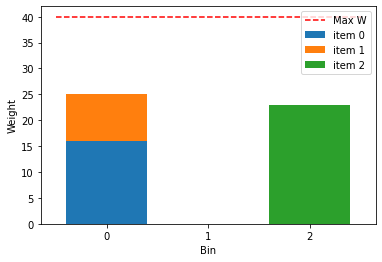

In [5]:
# convert from DOcplex model to Qiskit Quadratic program
qp = QuadraticProgram()
qp.from_docplex(mdl)

# Solving Quadratic Program using CPLEX
cplex = CplexOptimizer()
result = cplex.solve(qp)
print(result)
plot_bins(result, wj, n, m)

## 2. Simplifications of the problem

The problem variables can be reduce using the following simplifications:

- Removing unnecesary decision variables, $l = \mathrm{Int}\left(\frac{\sum_j^n \xi_{ij}}{Q}\right)$

- Assing the item 0 to bin 0, $\xi_{0,0} = 1$

Therefore, the number of variables after the simplifications and assuming $m = n$: 

$$m(n - 1) + (m - l) = (n^2 - l)$$

meanwhile for the original number of variables is:

$$mn+m = n^2 + n$$

a reduction of $(n + l)$ variables.

In [6]:
# Construct model using docplex
mdl = Model("BinPacking_simplify")

l = int(np.ceil(np.sum(wj)/Q))
x = mdl.binary_var_list([f"x{i}" for i in range(m)]) # list of variables that represent the bins
e =  mdl.binary_var_list([f"e{i//m},{i%m}" for i in range(n*m)]) # variables that represent the items on the specific bin

objective = mdl.sum([x[i] for i in range(n)])

mdl.minimize(objective)

for j in range(m):
    # First set of constraints: the items must be in any bin
    constraint0 = mdl.sum([e[i*m+j] for i in range(n)])
    mdl.add_constraint(constraint0 == 1, f"cons0,{j}")
    
for i in range(n):
    # Second set of constraints: weight constraints
    constraint1 = mdl.sum([wj[j] * e[i*m+j] for j in range(m)])
    mdl.add_constraint(constraint1 <= Q * x[i], f"cons1,{i}")


# Load quadratic program from docplex model
qp = QuadraticProgram()
qp.from_docplex(mdl)
# Simplifying the problem
for i in range(l):
    qp = qp.substitute_variables({f"x{i}":1}) 
qp = qp.substitute_variables({"e0,0":1}) 
for i in range(1,m):
    qp = qp.substitute_variables({f"e{i},0":0})
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: BinPacking_simplify

Minimize
 obj: x2 + 2
Subject To
 cons0,1: _e0,1 + _e1,1 + _e2,1 = 1
 cons0,2: _e0,2 + _e1,2 + _e2,2 = 1
 cons1,0: 9 _e0,1 + 23 _e0,2 <= 24
 cons1,1: 9 _e1,1 + 23 _e1,2 <= 40
 cons1,2: - 40 x2 + 9 _e2,1 + 23 _e2,2 <= 0

Bounds
 0 <= x2 <= 1
 0 <= _e0,1 <= 1
 0 <= _e0,2 <= 1
 0 <= _e1,1 <= 1
 0 <= _e1,2 <= 1
 0 <= _e2,1 <= 1
 0 <= _e2,2 <= 1

Binaries
 x2 _e0,1 _e0,2 _e1,1 _e1,2 _e2,1 _e2,2
End



optimal function value: 2.0
optimal value: [0. 0. 0. 1. 1. 0. 0.]
status: SUCCESS


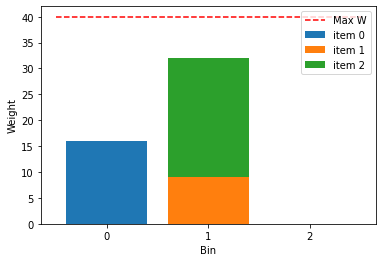

In [7]:
simplify_result = cplex.solve(qp)
print(simplify_result)
plot_bins(simplify_result, wj, n, m, l, simplify=True)

## 2.3 QUBO Representation

### Conversion to QUBO
Qiskit's optimization module provides converters for Quadratic programs.

In [8]:
ineq2eq = InequalityToEquality()
qp_eq = ineq2eq.convert(qp)
print(qp_eq.export_as_lp_string())
print(f"The number of variables is {qp_eq.get_num_vars()}")

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: BinPacking_simplify

Minimize
 obj: x2 + 2
Subject To
 cons0,1: _e0,1 + _e1,1 + _e2,1 = 1
 cons0,2: _e0,2 + _e1,2 + _e2,2 = 1
 cons1,0: 9 _e0,1 + 23 _e0,2 + cons1,0@int_slack = 24
 cons1,1: 9 _e1,1 + 23 _e1,2 + cons1,1@int_slack = 40
 cons1,2: - 40 x2 + 9 _e2,1 + 23 _e2,2 + cons1,2@int_slack = 0

Bounds
 0 <= x2 <= 1
 0 <= _e0,1 <= 1
 0 <= _e0,2 <= 1
 0 <= _e1,1 <= 1
 0 <= _e1,2 <= 1
 0 <= _e2,1 <= 1
 0 <= _e2,2 <= 1
       cons1,0@int_slack <= 24
       cons1,1@int_slack <= 40
       cons1,2@int_slack <= 40

Binaries
 x2 _e0,1 _e0,2 _e1,1 _e1,2 _e2,1 _e2,2

Generals
 cons1,0@int_slack cons1,1@int_slack cons1,2@int_slack
End

The number of variables is 10


In [9]:
int2bin = IntegerToBinary()
qp_eq_bin = int2bin.convert(qp_eq)
print(qp_eq_bin.export_as_lp_string())
print(f"The number of variables is {qp_eq_bin.get_num_vars()}")

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: BinPacking_simplify

Minimize
 obj: x2 + 2
Subject To
 cons0,1: _e0,1 + _e1,1 + _e2,1 = 1
 cons0,2: _e0,2 + _e1,2 + _e2,2 = 1
 cons1,0: 9 _e0,1 + 23 _e0,2 + cons1,0@int_slack@0 + 2 cons1,0@int_slack@1
          + 4 cons1,0@int_slack@2 + 8 cons1,0@int_slack@3
          + 9 cons1,0@int_slack@4 = 24
 cons1,1: 9 _e1,1 + 23 _e1,2 + cons1,1@int_slack@0 + 2 cons1,1@int_slack@1
          + 4 cons1,1@int_slack@2 + 8 cons1,1@int_slack@3
          + 16 cons1,1@int_slack@4 + 9 cons1,1@int_slack@5 = 40
 cons1,2: - 40 x2 + 9 _e2,1 + 23 _e2,2 + cons1,2@int_slack@0
          + 2 cons1,2@int_slack@1 + 4 cons1,2@int_slack@2
          + 8 cons1,2@int_slack@3 + 16 cons1,2@int_slack@4
          + 9 cons1,2@int_slack@5 = 0

Bounds
 0 <= x2 <= 1
 0 <= _e0,1 <= 1
 0 <= _e0,2 <= 1
 0 <= _e1,1 <= 1
 0 <= _e1,2 <= 1
 0 <= _e2,1 <= 1
 0 <= _e2,2 <= 1
 0 <= cons1,0@int_slack@0 <= 1
 0 <= cons1,0@int_slack@1 <= 1
 0 <= cons1,0@int_slack@

In [10]:
lineq2penalty = LinearEqualityToPenalty()
qubo = lineq2penalty.convert(qp_eq_bin)
print(f"The number of variables is {qp_eq_bin.get_num_vars()}")
print(qubo.export_as_lp_string())

The number of variables is 24
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: BinPacking_simplify

Minimize
 obj: x2 - 868 _e0,1 - 2212 _e0,2 - 1444 _e1,1 - 3684 _e1,2 - 4 _e2,1 - 4 _e2,2
      - 96 cons1,0@int_slack@0 - 192 cons1,0@int_slack@1
      - 384 cons1,0@int_slack@2 - 768 cons1,0@int_slack@3
      - 864 cons1,0@int_slack@4 - 160 cons1,1@int_slack@0
      - 320 cons1,1@int_slack@1 - 640 cons1,1@int_slack@2
      - 1280 cons1,1@int_slack@3 - 2560 cons1,1@int_slack@4
      - 1440 cons1,1@int_slack@5 + [ 6400 x2^2 - 2880 x2*_e2,1 - 7360 x2*_e2,2
      - 320 x2*cons1,2@int_slack@0 - 640 x2*cons1,2@int_slack@1
      - 1280 x2*cons1,2@int_slack@2 - 2560 x2*cons1,2@int_slack@3
      - 5120 x2*cons1,2@int_slack@4 - 2880 x2*cons1,2@int_slack@5 + 328 _e0,1^2
      + 1656 _e0,1*_e0,2 + 8 _e0,1*_e1,1 + 8 _e0,1*_e2,1
      + 72 _e0,1*cons1,0@int_slack@0 + 144 _e0,1*cons1,0@int_slack@1
      + 288 _e0,1*cons1,0@int_slack@2 + 576 _e0,1*cons1,0@int_slack@3
     

In [11]:
result = cplex.solve(qubo)
print(result)

optimal function value: 2.0
optimal value: [0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
status: SUCCESS


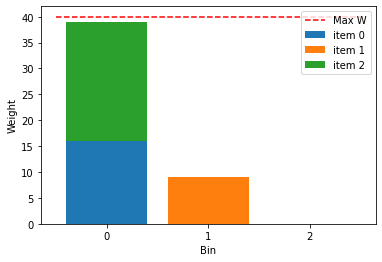

In [12]:
data_bins(result.x, wj, n, m, l=l, simplify=True)
plot_bins(result, wj, n, m, l=l, simplify=True)

### Solving using QAOA

After transforming the problem to the QUBO's representation. It's possible to use the QAOA solver of qiskit. In this section we present the results using QAOA.

In [13]:
from qiskit import Aer
backend = Aer.get_backend("qasm_simulator")

In [14]:
qaoa = MinimumEigenOptimizer(QAOA(reps=3, quantum_instance=backend))
result_qaoa = qaoa.solve(qubo)
print(result_qaoa)

optimal function value: 53.0
optimal value: [1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
status: SUCCESS


Text(0.5, 1.0, 'QAOA solution')

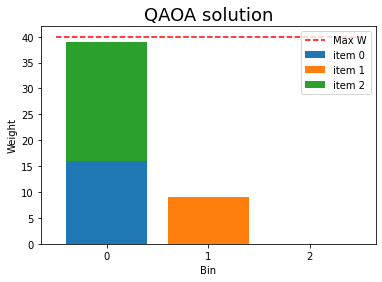

In [15]:
plot_bins(result, wj, n, m, l, simplify=True)
plt.title("QAOA solution", fontsize=18)

## 2.4) Bin-packing problem - my approach

Translating the inequality constraints to equality constraints has a large cost in terms of qubits. What if we use a penalty in terms of an exponential function non-symmetric to the maximal weight. The function should have a large penalty when the maximal weight of a bin is overpassed. In this case, I suggest the following constraint:
Penality:

$$e^{-x} \approx 1 - x + x^2/2$$

Text(0, 0.5, 'f(x)')

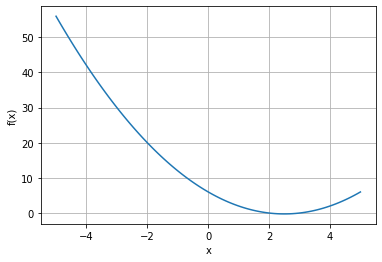

In [16]:
# Proposal
plt.figure()
alpha = -2
x = np.linspace(-5,5,100)
f = (-(x+alpha) + (x+alpha)**2)
plt.plot(x,f)
plt.grid()
plt.xlabel("x")
plt.ylabel("f(x)")

#### The new objective:

Using the problem in section 7.1 presented in Gambella 2021. Here, we will implement case 1. Small size bin packing problem with a number of items n = 2, 3, 4 with items weight $w_j$ randomly picked [1,Q].

- n is the number of items
- m is the number of bins
- $w_j$ is the items weight

$$\underset{\chi, \xi}{minimize}\sum_{i=1}^m \chi_i + \alpha\left[-\sum_{i=1}^{m}\left(Q \chi_i -\sum_{j=1}^n w_{j}\xi_{ij}\right) + \left(\sum_{i=1}^{m}\left( Q \chi_i -\sum_{j=1}^n w_{j}\xi_{ij}\right)\right)^2\right]$$

subject to:

 $$\sum_{i=1}^m \xi_{ij} = 1 \qquad j=1,...,n$$
 $$\sum_{j=1}^n w_{j}\xi_{ij} \le Q \chi_i \qquad i = 1, ..., m$$
 $$\xi_{ij}\in  \{0,1\} \qquad i=1,..,m \qquad j=1,..,n$$
 $$\chi_{i}\in  \{0,1\} \qquad i=1,..,m $$

In [17]:
# Construct model using docplex
mdl = Model("binPackingMyApproach")

x = mdl.binary_var_list([f"x{i}" for i in range(n)]) # list of variables that represent the bins
e =  mdl.binary_var_list([f"e{i//m},{i%n}" for i in range(n*m)]) # variables that represent the items on the specific bin

objective = mdl.sum([x[i] for i in range(m)])
cons = 0
alpha = -10
for i in range(m):
    cons_1 = 0
    cons_1 += Q*x[i]
    for j in range(n):
        cons_1 -= wj[j]*e[i*m+j]
    cons += (-(cons_1+alpha) + (cons_1+alpha)**2)

mdl.minimize(objective + cons)

for j in range(m):
    # First set of constraints: the items must be in any bin
    constraint0 = mdl.sum([e[i*m+j] for i in range(n)])
    mdl.add_constraint(constraint0 == 1, f"cons0,{j}")
    
# # Load quadratic program from docplex model
qp = QuadraticProgram()
qp.from_docplex(mdl)
# Simplifying the problem
for i in range(l):
    qp = qp.substitute_variables({f"x{i}":1}) 
qp = qp.substitute_variables({"e0,0":1}) 
for i in range(1,m):
    qp = qp.substitute_variables({f"e{i},0":0})
print(qp.export_as_lp_string())
print(f"The number of variables is {qp.get_num_vars()}")

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: binPackingMyApproach

Minimize
 obj: - 839 x2 - 243 _e0,1 - 621 _e0,2 - 531 _e1,1 - 1357 _e1,2 + 189 _e2,1
      + 483 _e2,2 + [ 3200 x2^2 - 1440 x2*_e2,1 - 3680 x2*_e2,2 + 162 _e0,1^2
      + 828 _e0,1*_e0,2 + 1058 _e0,2^2 + 162 _e1,1^2 + 828 _e1,1*_e1,2
      + 1058 _e1,2^2 + 162 _e2,1^2 + 828 _e2,1*_e2,2 + 1058 _e2,2^2 ]/2 + 1164
Subject To
 cons0,1: _e0,1 + _e1,1 + _e2,1 = 1
 cons0,2: _e0,2 + _e1,2 + _e2,2 = 1

Bounds
 0 <= x2 <= 1
 0 <= _e0,1 <= 1
 0 <= _e0,2 <= 1
 0 <= _e1,1 <= 1
 0 <= _e1,2 <= 1
 0 <= _e2,1 <= 1
 0 <= _e2,2 <= 1

Binaries
 x2 _e0,1 _e0,2 _e1,1 _e1,2 _e2,1 _e2,2
End

The number of variables is 7


optimal function value: 174.0
optimal value: [0. 1. 0. 0. 1. 0. 0.]
status: SUCCESS


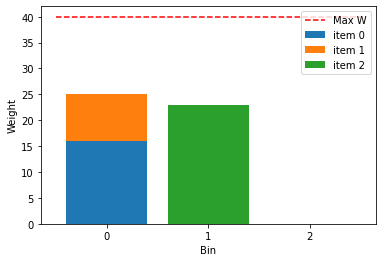

In [18]:
# Solving Quadratic Program using CPLEX
cplex = CplexOptimizer()
result = cplex.solve(qp)
print(result)
plot_bins(result, wj, n, m, l, simplify=True)


optimal function value: 174.0
optimal value: [0. 1. 0. 0. 1. 0. 0.]
status: SUCCESS


Text(0.5, 1.0, 'QAOA solution')

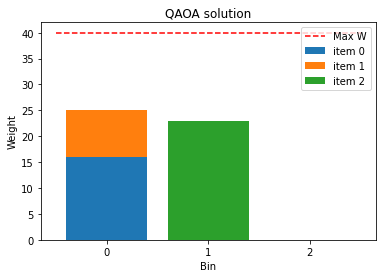

In [19]:
qubo_myapp = lineq2penalty.convert(qp)
result_myapp = qaoa.solve(qubo_myapp)
print(result_myapp)
plot_bins(result_myapp, wj, n, m, l, simplify=True)
plt.title("QAOA solution")

In [20]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright